# Covid vaccines used by country worldwide

As I was curious about the usage of the different vaccins worldwide, I decided to make a Notebook about it. As Gabriel Preda already made a dataset with the required data downloaded from Our World in Data, I am using his dataset.

## Table of contents
[**1. Loading and preparing data**](#1.-Loading-and-preparing-data)

[**2. Which vaccines are used where?**](#2.-Which-vaccines-are-used-where?)

[2.1 Worldwide usage maps by vaccin](#2.1-Worldwide-usage-maps-by-vaccin)

[2.2 Worldwide map plotting the number of vaccines used by country](#2.2-Worldwide-map-plotting-the-number-of-vaccines-used-by-country)

[2.3 Usage of vaccines in Europe by country](#2.3-Usage-of-vaccines-in-Europe-by-country)

[2.4 Usage of vaccines in Europe over time](#2.4-Usage-of-vaccines-in-Europe-over-time)

[**3. Overall vaccination rates**](#3.-Overall-vaccination-rates)


In [14]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import plotly.express as px
import plotly.graph_objs as go

In [15]:
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [16]:
import warnings
warnings.filterwarnings("ignore")

# 1. Loading and preparing data

In [17]:
!pwd

/kaggle/working


In [18]:
!ls -1 /kaggle/input/covid-world-vaccination-progress/country_vaccinations_by_manufacturer.csv

/kaggle/input/covid-world-vaccination-progress/country_vaccinations_by_manufacturer.csv


In [19]:
manu = pd.read_csv("/kaggle/input/covid-world-vaccination-progress/country_vaccinations_by_manufacturer.csv")
manu['date'] = pd.to_datetime(manu.date)

In [20]:
country = pd.read_csv("/kaggle/input/covid-world-vaccination-progress/country_vaccinations.csv")
country['date'] = pd.to_datetime(country.date)

The file with country vaccinations by manufacturer seems most promising as it holds detailed information the vaccinations given per vaccine per date per country.

In [21]:
manu.head()

,location,date,vaccine,total_vaccinations
0,Austria,2021-01-05,Johnson&Johnson,0
1,Austria,2021-01-05,Moderna,0
2,Austria,2021-01-05,Oxford/AstraZeneca,0
3,Austria,2021-01-05,Pfizer/BioNTech,30885
4,Austria,2021-01-12,Johnson&Johnson,0


However, it turns out that this information is only available for a limited number of countries.

In [22]:
manu.location.unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Chile', 'Croatia', 'Cyprus',
       'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'United States', 'Uruguay'], dtype=object)

Although less ideal, it turns out that the country file holds a column that specifies all vaccins used in a country

In [23]:
#temporarily set max max_colwidth to None
pd.set_option('display.max_colwidth', None)
country[['country', 'date', 'vaccines']].head()

,country,date,vaccines
0,Afghanistan,2021-02-22,"BBIBP-CorV, Oxford/AstraZeneca, Pfizer/BioNTech"
1,Afghanistan,2021-02-23,"BBIBP-CorV, Oxford/AstraZeneca, Pfizer/BioNTech"
2,Afghanistan,2021-02-24,"BBIBP-CorV, Oxford/AstraZeneca, Pfizer/BioNTech"
3,Afghanistan,2021-02-25,"BBIBP-CorV, Oxford/AstraZeneca, Pfizer/BioNTech"
4,Afghanistan,2021-02-26,"BBIBP-CorV, Oxford/AstraZeneca, Pfizer/BioNTech"


Now, I want to keep the best-known vaccins (Pfizer, Moderna, AstraZeneca and Johnson&Johnson) as they are and group lesser-known brands into the countries where they are made.

In [24]:
#strip text
country['vaccines'] = country['vaccines'].str.replace("/Beijing|/Wuhan|/HayatVax|/BioNTech|Oxford/", "", regex=True)

#replace with Chinese vaccins
country['vaccines'] = country['vaccines'].str.replace("Sinopharm|BBIBP-CorV|Sinovac|CanSino|RBD-Dimer", "Chinese", regex=True)

#replace with Russian vaccins
country['vaccines'] = country['vaccines'].str.replace("EpiVacCorona|Sputnik V", "Russian", regex=True)

#replace with Cuban vaccins
country['vaccines'] = country['vaccines'].str.replace("Soberana02|Abdala", "Cuban", regex=True)

#replace some others
to_replace = {'Covaxin': 'Indian',
              'QazVac': 'Kazachstan'}
country['vaccines'] = country['vaccines'].replace(to_replace, regex=True)

In [25]:
#making a list of all vaccins
vac_list = [x.split(", ") for x in country.vaccines.values]
vaccins = [item for elem in vac_list for item in elem]
vaccins = set(vaccins)
vaccins = list(vaccins)
vaccins

['Johnson&Johnson',
 'Pfizer',
 'Chinese',
 'Indian',
 'Kazachstan',
 'Cuban',
 'AstraZeneca',
 'Russian',
 'Moderna']

Now, I want to add a column with True/False for each vaccin, and only keep the row with the most recent information for each country.

In [26]:
#adding a column with True/False for each vaccin
for vaccin in vaccins:
    country[vaccin] = np.where(country['vaccines'].str.contains(vaccin), True, False)

country = country.sort_values(by = ['country', 'date'], ascending = [True, False])
country_latest = country.drop_duplicates(subset = "country", keep = "first")

#head of selected columns only
country_latest.iloc[:, np.r_[0,12, 15:len(country_latest.columns)]].head()

,country,vaccines,Johnson&Johnson,Pfizer,Chinese,Indian,Kazachstan,Cuban,AstraZeneca,Russian,Moderna
120,Afghanistan,"Chinese, AstraZeneca, Pfizer",False,True,True,False,False,False,True,False,False
283,Albania,"AstraZeneca, Pfizer, Chinese, Russian",False,True,True,False,False,False,True,True,False
412,Algeria,"AstraZeneca, Russian",False,False,False,False,False,False,True,True,False
553,Andorra,"AstraZeneca, Pfizer",False,True,False,False,False,False,True,False,False
665,Angola,AstraZeneca,False,False,False,False,False,False,True,False,False


# 2. Which vaccines are used where?

## 2.1 Worldwide usage maps by vaccin

Below, I am making a function that allows me to specify which vaccin I want to display on a worldwide map and the color that I want to give to the countries using the vaccin.

In [27]:
def plot_vaccin(color, vaccin):
    fig = px.choropleth(country_latest, locations="iso_code",
                        color=vaccin,
                        hover_name="country",
                        color_discrete_map={True: color, False: 'lightgrey'})

    layout = go.Layout(
        title=go.layout.Title(
            text= f"<b>Countries using {vaccin} vaccin</b>",
            x=0.5
        ),
        showlegend=False,
        font=dict(size=14),
        width = 750,
        height = 350,
        margin=dict(l=0,r=0,b=0,t=30)
    )

    fig.update_layout(layout)

    fig.show()

As we can see, Pfizer is used a lot in the Western world.

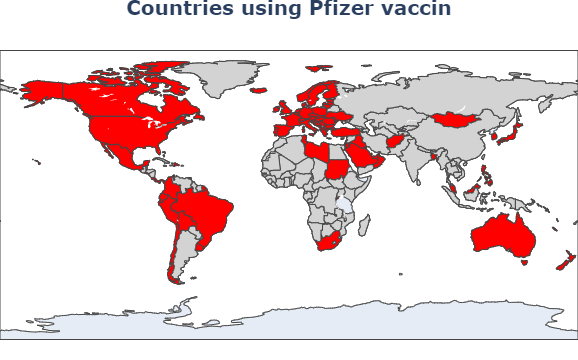

In [28]:
plot_vaccin('red', 'Pfizer')

Moderna's footprint of countries is smaller as it is mostly the US, Canada and Europe.

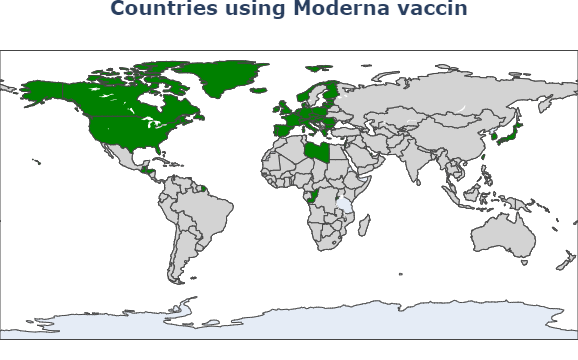

In [29]:
plot_vaccin('green', "Moderna")

AstraZeneca is used in a lot of countries including most African and South American countries. Some noticable countries missing here are the US, South Africa and some European countries such as Norway and Denmark.

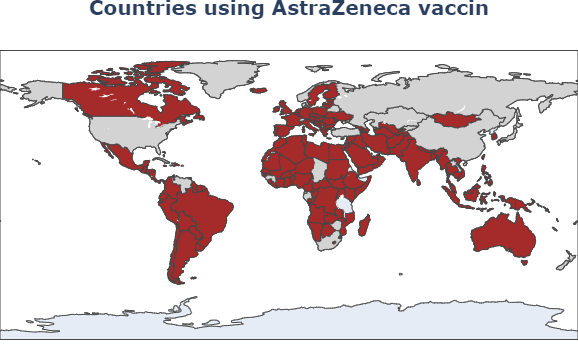

In [30]:
plot_vaccin('brown', "AstraZeneca")

Johnson & Johnson's footprint is smaller. Noticable is that South Africa uses Johnson & Johnson while not using AstraZenca (the opposite of most African countries).

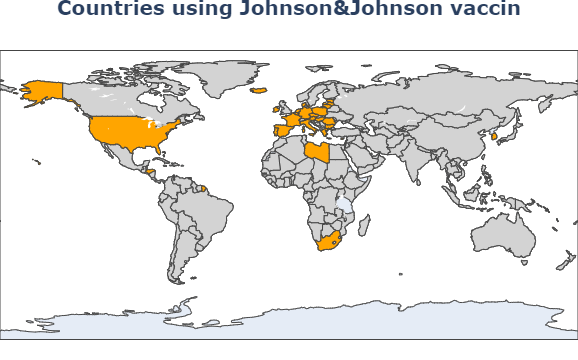

In [31]:
plot_vaccin('orange', "Johnson&Johnson")

Chinese brands are used in a lot of Asian countries and also almost all South American countries use at least some Chinese vaccins.

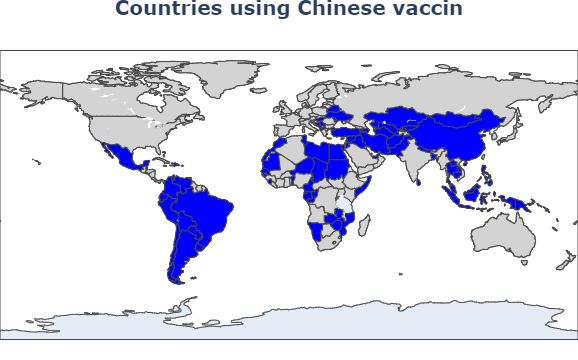

In [32]:
plot_vaccin('blue', "Chinese")

Besides Russia itself, there is a significant number of countries also using Russian vaccins (I suppose mostly Sputnik as I had not heard about the other Russian vaccin yet).

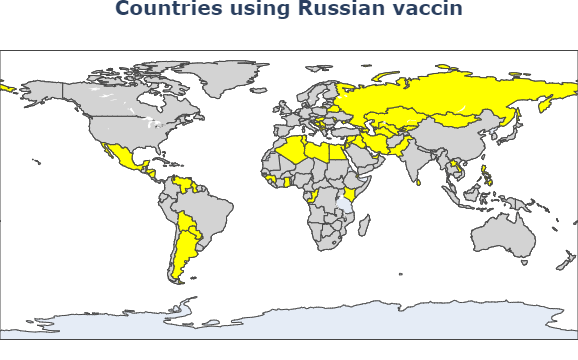

In [33]:
plot_vaccin('yellow', "Russian")

The Indian vaccin (Covaxin) is used in India and a few other countries.

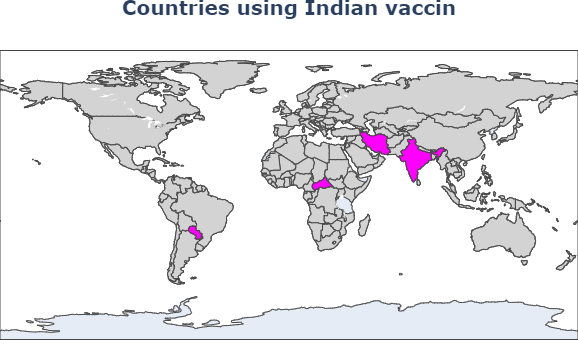

In [34]:
plot_vaccin('magenta', "Indian")

I had not heard about the Cuban vaccins yet, but it turns out that those are only used in Cuba itself.

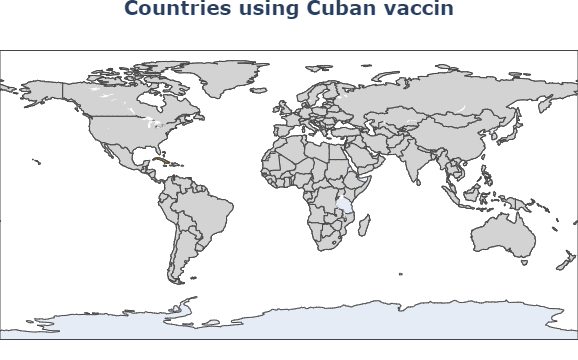

In [35]:
plot_vaccin('goldenrod', "Cuban")

The same things applies for the vaccin made in Kazachstan: it is only used in the country itself.

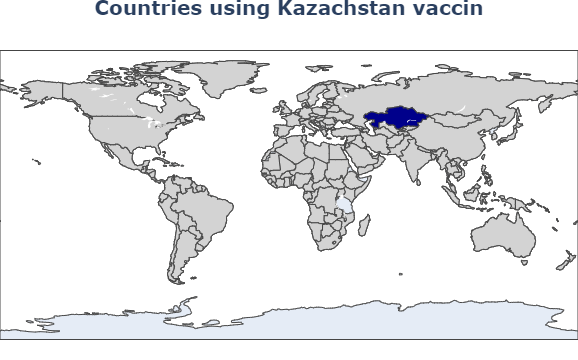

In [36]:
plot_vaccin('darkblue', "Kazachstan")

## 2.2 Worldwide map plotting the number of vaccines used by country

As you can see, many countries use only one or two different vaccines.

In [37]:
country_latest['Vaccins_used']= country_latest.iloc[:, -9:].sum(axis=1)
country_latest.Vaccins_used.value_counts()

1    68
2    61
3    45
4    41
6     2
Name: Vaccins_used, dtype: int64

Noticable is that only Libya and Hungary use more than 4 different vaccines.

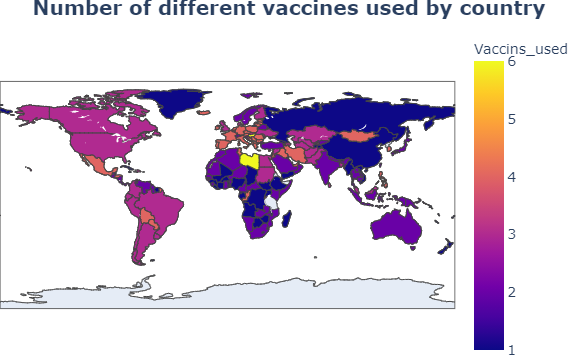

In [38]:
fig = px.choropleth(country_latest, locations="iso_code",
                    color='Vaccins_used',
                    hover_data= ["country", "vaccines"])

layout = go.Layout(
    title=go.layout.Title(
        text= f"<b>Number of different vaccines used by country</b>",
        x=0.5
    ),
    font=dict(size=14),
    width = 750,
    height = 350,
    margin=dict(l=0,r=0,b=0,t=30)
)

fig.update_layout(layout)

fig.show()

## 2.3 Usage of vaccines in Europe by country

As mentioned before, the file by manufacturer does not hold all countries. However, it does contain detailed info on most European countries. I decided to get rid of the 3 countries outside Europe and to dig deeper anyway.

In [39]:
non_european = ['Chile', 'United States', 'Uruguay']
manu = manu.query('location not in @non_european')
manu.location.nunique()

29

By just checking some info of my own country, I see that the numbers are clearly cumulatief.

In [40]:
manu[manu.location == "Netherlands"].tail(8)

,location,date,vaccine,total_vaccinations
5612,Netherlands,2021-06-08,Johnson&Johnson,431258
5613,Netherlands,2021-06-08,Moderna,929801
5614,Netherlands,2021-06-08,Oxford/AstraZeneca,2318213
5615,Netherlands,2021-06-08,Pfizer/BioNTech,8624946
5616,Netherlands,2021-06-15,Johnson&Johnson,438795
5617,Netherlands,2021-06-15,Moderna,990361
5618,Netherlands,2021-06-15,Oxford/AstraZeneca,2411411
5619,Netherlands,2021-06-15,Pfizer/BioNTech,9084078


In [41]:
manu_totals = manu.copy()

#keeping only the latest info
manu_totals = manu_totals.sort_values(by = ['location', 'date', 'vaccine'], ascending = [True, False, True])
manu_totals = manu_totals.drop(columns = "date")
manu_totals = manu_totals.drop_duplicates(subset = ['location', 'vaccine'], keep = "first")

manu_totals = manu_totals.pivot(index = ['location'], columns = 'vaccine', values = 'total_vaccinations')
manu_totals = manu_totals.fillna(0)
manu_totals.iloc[:, -6:] = manu_totals.iloc[:, -6:].astype(int)

#convert to percent
cols = list(manu_totals.columns)
manu_totals[cols] = manu_totals[cols].div(manu_totals[cols].sum(axis=1), axis=0).multiply(100)
manu_totals = manu_totals.round(1)
                                
#adding ISO codes from my own dataset https://www.kaggle.com/erikbruin/countries-of-the-world-iso-codes-and-population
countries_iso = pd.read_csv("../input/countries-of-the-world-iso-codes-and-population/country_codes_2020.csv")
countries_iso = countries_iso.rename(columns = {'name': 'location', 'cca3': 'iso_code'})

manu_totals = manu_totals.reset_index()
manu_totals = manu_totals.merge(countries_iso[['location', 'iso_code']], on = 'location', how = "left")

However, this time I am interested to see what percentage of vaccines uses was mRNA (Pfizer and Moderna).

In [42]:
manu_totals['mRNA'] = manu_totals['Moderna'] + manu_totals['Pfizer/BioNTech']
manu_totals.head()

,location,Johnson&Johnson,Moderna,Oxford/AstraZeneca,Pfizer/BioNTech,Sinopharm/Beijing,Sputnik V,iso_code,mRNA
0,Austria,1.3,9.9,17.3,71.5,0.0,0.0,AUT,81.4
1,Belgium,2.0,8.6,20.1,69.3,0.0,0.0,BEL,77.9
2,Bulgaria,1.6,12.8,28.9,56.7,0.0,0.0,BGR,69.5
3,Croatia,0.8,11.1,20.7,67.4,0.0,0.0,HRV,78.5
4,Cyprus,1.7,8.3,25.6,64.4,0.0,0.0,CYP,72.7


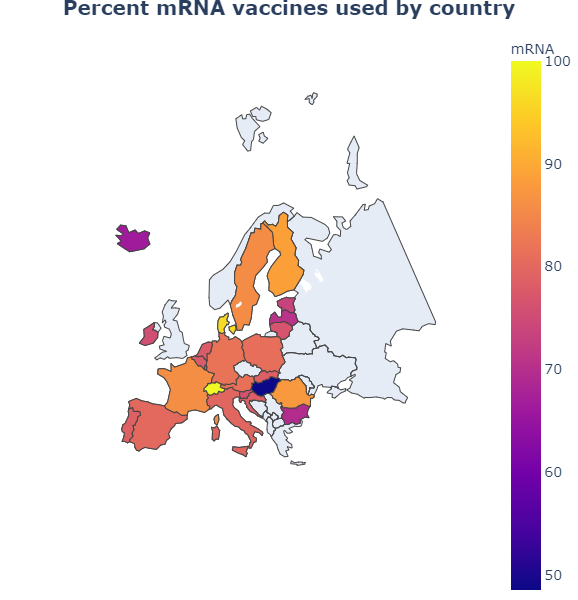

In [43]:
fig = px.choropleth(manu_totals, locations="iso_code",
                    color='mRNA',
                    hover_data= ["location"])

layout = go.Layout(
    title=go.layout.Title(
        text= f"<b>Percent mRNA vaccines used by country</b>",
        x=0.5
    ),
    font=dict(size=14),
    autosize=False,
    width = 800,
    height = 600,
    margin=dict(l=0,r=0,b=0,t=30)
)
fig.update_geos(scope="europe")
fig.update_layout(layout)

fig.show()


We see that especially Hungary uses a lot less mRNA. This is because Hungary is the only European country that also uses Sputnik and Sinopharm.

In [44]:
manu_totals[manu_totals.location == "Hungary"]

,location,Johnson&Johnson,Moderna,Oxford/AstraZeneca,Pfizer/BioNTech,Sinopharm/Beijing,Sputnik V,iso_code,mRNA
11,Hungary,0.8,6.4,10.6,42.1,21.3,18.8,HUN,48.5


## 2.4 Usage of vaccines in Europe over time


In [45]:
manu = manu.sort_values(by=['location', 'vaccine', 'date'], ascending = [True, True, False])
manu = manu.reset_index(drop=True)

manu['new'] = 0
for i in range(len(manu)-1):
    if ((manu.loc[i+1, 'vaccine'] == manu.loc[i, 'vaccine']) & (manu.loc[i+1, 'location'] == manu.loc[i, 'location'])):
        manu.loc[i, 'new'] = (manu.loc[i, 'total_vaccinations'] - manu.loc[i+1, 'total_vaccinations'])
    else:
        manu.loc[i, 'new'] = manu.loc[i, 'total_vaccinations']
        
manu.head()

,location,date,vaccine,total_vaccinations,new
0,Austria,2021-06-15,Johnson&Johnson,91523,13793
1,Austria,2021-06-08,Johnson&Johnson,77730,21016
2,Austria,2021-06-01,Johnson&Johnson,56714,19230
3,Austria,2021-05-25,Johnson&Johnson,37484,12027
4,Austria,2021-05-18,Johnson&Johnson,25457,12170


In [46]:
new_vaccines = manu[['date', 'vaccine', 'new']]

df = new_vaccines[['date', 'vaccine']]
df.drop_duplicates(inplace = True)
df = df.sort_values(by = ['vaccine', 'date'], ascending = [True, False]).reset_index(drop=True)
df['before'] = 0

for i,row in df.iterrows():
    total_before = new_vaccines[((new_vaccines.vaccine == row.vaccine) & (new_vaccines.date <= row.date))]['new'].sum()
    df.loc[i, 'before'] = total_before
    
df = df.pivot(index= 'date', columns = 'vaccine', values = 'before')
df = df[['Johnson&Johnson', 'Moderna', 'Oxford/AstraZeneca', 'Pfizer/BioNTech']] #getting rid of Sputnik and Sinopharm
df.head()

vaccine,Johnson&Johnson,Moderna,Oxford/AstraZeneca,Pfizer/BioNTech
date,,,,
2020-12-16,NaN,NaN,NaN,1.0
2020-12-20,NaN,2.0,NaN,NaN
2020-12-22,NaN,NaN,NaN,3.0
2020-12-27,0.0,4.0,0.0,35239.0
2020-12-28,0.0,4.0,0.0,61283.0


As you can see below, Europe is increasingly relying on Pfizer. While Pfizer was used the most since the start of the vaccinations, the trend is also upward. The amounts used of Moderna and AstraZeneca are also significant. Johnson& Johnson is not used a lot yet.

In [47]:
df.iplot(mode = 'lines', xTitle = 'Date', yTitle = 'Total vaccinations', title = 'Cumulative vaccinations in Europe by vaccine')

# 3. Overall vaccination rates

Next version ;-)

**To be continued: Please stay tuned!**